# Decomposition into AngleBasis demo

This demo uses the OpenNeuro dataset ds004144 on Fibromyalgia containing 66 subjects.

Two types of scans were taken: resting state and epr

Try testing with either one

Best results with ensemble of high #basis reconstruction and one-basis residual

In [10]:
# Get data

import requests as req
import os
from pathlib import Path

if not os.path.exists('../data'):
    os.makedirs('../data')
    
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    
for file in ['fc.pkl', 'Clinical_fm_66_.csv', 'fcvec.pkl']:
    if not Path(f'../data/{file}').exists():
        r = req.get(f'http://hunimal.org/AngleBasis/{file}', headers=headers)
        with open(f'../data/{file}', 'wb') as f:
            f.write(r.content)
        print(f'Fetched {file}')
    else:
        print(f'{file} exists')
    
print('Complete')

fc.pkl exists
Clinical_fm_66_.csv exists
fcvec.pkl exists
Complete


In [20]:
# Load fMRI-derived FC

import pickle

def vec2mat(vec, d, show_diag=True):
    a,b = np.triu_indices(d,1)
    x = np.eye(d) if show_diag else np.zeros((d,d))
    x[a,b] = vec
    x[b,a] = vec
    return x

def mat2vec(mat):
    a,b = np.triu_indices(mat.shape[0],1)
    return mat[a,b]

fcvec = pickle.load(open('../data/fcvec.pkl', 'rb'))
fc = pickle.load(open('../data/fc.pkl', 'rb'))

print('Done')

Done


In [12]:
# Load clinical data

import pandas as pd

df = pd.read_csv('../data/Clinical_fm_66_.csv', sep=',')
print(df)

    rid  gp  1_age  1_sch_deg  1_yr_study  1_marital_st  1_occ  1_occ_t  \
0     2   0     50          1         6.0             2      5        0   
1     4   0     43          6        22.0             2      6        1   
2     5   0     40          3        16.0             3      5        0   
3     6   0     42          6        19.0             2      5        0   
4     7   1     43          6        25.0             2      1        1   
..  ...  ..    ...        ...         ...           ...    ...      ...   
61   73   1     37          6        20.0             1      1        3   
62   74   1     40          6        18.5             2      6        1   
63   75   1     45          5        15.5             2      1        3   
64   76   1     43          4        12.0             2      5        0   
65   77   1     42          5        16.0             1      2        1   

    1_m_inc  1_inc_dep  ...  15_9  15_10  15_11  16_int_task_ti  16_w  16_h  \
0      4000        1

In [13]:
# Use the rest or epr task

import numpy as np

vals = df[['rid','gp']].to_numpy()
x = []
y = []

for task in ['rest']:
    for a,b in vals:
        try:
            p = fcvec[task][a]
        except:
            continue
        x.append(p)
        y.append(b)
    
x = np.stack(x)
y = np.array(y)

print([z.shape for z in [x,y]])

[(66, 34716), (66,)]


In [34]:
# Calculate angle basis (requires GPU, takes several minutes for 66 subjects)

import sys

if '../..' not in sys.path:
    sys.path.append('../..')
    
import AngleBasis as ab

rec = [] # Reconstruction
res = [] # Residual
bas = []

for i,p in enumerate(x):
    P = vec2mat(p, 264)
    # 1: Number of bases to use (try 1-20)
    b = ab.fc2ab(P, 1, use_jitter=True, use_angle=True)
    bas.append(b)
    r = ab.ab2fc(b)
    s = P-r
    rec.append(mat2vec(r))
    res.append(mat2vec(s))
    if i % 5 == 0:
        print(f'Done {i}')
    
rec = np.stack(rec)
res = np.stack(res)

print(rec.shape, res.shape)
print('Complete')

Done 0
Done 5
Done 10
Done 15
Done 20
Done 25
Done 30
Done 35
Done 40
Done 45
Done 50
Done 55
Done 60
Done 65
(66, 34716) (66, 34716)
Complete


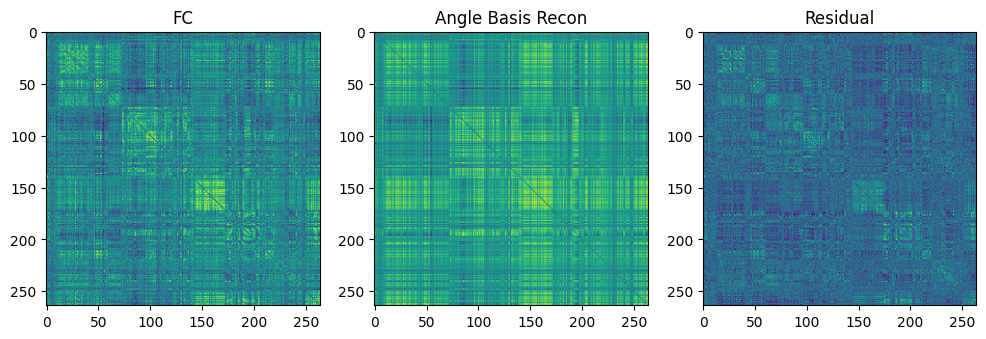

In [35]:
# Check angle basis

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(12,5))

ax[0].imshow(vec2mat(x[0], 264, show_diag=False))
ax[0].set_title('FC')

ax[1].imshow(vec2mat(rec[0], 264, show_diag=False))
ax[1].set_title('Angle Basis Recon')

ax[2].imshow(vec2mat(res[0], 264, show_diag=False))
ax[2].set_title('Residual')

fig.show()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

fcauc = []
recauc = []
resauc = []

for i in range(10):
    xtr, xt, xrtr, xrt, xstr, xst, ytr, yt = train_test_split(x,rec,res,y,stratify=y,train_size=0.8)

    reg = LogisticRegression(C=1e-2, max_iter=100).fit(xtr, ytr)
    p = reg.predict_proba(xt)
    auc = roc_auc_score(yt, p[:,1])
    fcauc.append(auc)
    print(auc)
    
    reg = LogisticRegression(C=1e-2, max_iter=100).fit(xrtr, ytr)
    p = reg.predict_proba(xrt)
    auc = roc_auc_score(yt, p[:,1])
    recauc.append(auc)
    print(auc)
    
    reg = LogisticRegression(C=1e-2, max_iter=100).fit(xstr, ytr)
    p = reg.predict_proba(xst)
    auc = roc_auc_score(yt, p[:,1])
    resauc.append(auc)
    print(auc)

print('---')
    
for auc in [fcauc, recauc, resauc]:
    print(np.mean(auc), np.std(auc))

0.5714285714285714
0.4897959183673469
0.653061224489796
0.5102040816326531
0.5714285714285714
0.6530612244897959
0.5714285714285714
0.4897959183673469
0.7142857142857143
0.38775510204081637
0.4489795918367347
0.6938775510204082
0.5918367346938775
0.5510204081632653
0.673469387755102
0.5510204081632653
0.5102040816326531
0.5510204081632653
0.6122448979591837
0.5510204081632654
0.7755102040816326
0.6122448979591837
0.6122448979591836
0.7142857142857143
0.5714285714285714
0.4489795918367347
0.5714285714285714
0.4489795918367347
0.5102040816326531
0.5510204081632653
---
0.5428571428571428 0.06962743718053868
0.5183673469387755 0.05015594174467144
0.6551020408163265 0.07212488590641754
